# 1. Импорты и Настройки

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Фиксируем сид для воспроизводимости тестов библиотеки
torch.manual_seed(42)
np.random.seed(42)

# 2. BayesianLinear
Это базовый строительный блок. В отличие от nn.Linear, он хранит не веса, а параметры распределений ($μ$ и $ρ$).

1) Параметризация: Мы не храним
$σ$ (стандартное отклонение) напрямую, так как оно должно быть строго положительным. Оптимизаторы не умеют соблюдать ограничения. Поэтому мы храним $ρ$ и делаем $\sigma = \text{softplus}(\rho)$.


2) Local Reparameterization Trick: В методе ```forward``` мы не сэмплируем матрицу весов
$W$. Это дорого и дает шумные градиенты. Мы сэмплируем активации. Математически это эквивалентно, но работает быстрее и стабильнее.


3) Инициализация: Байесовские сети очень чувствительны к старту. rho инициализируется так, чтобы начальная $\sigma$ была маленькой (например, ≈ 0.05).

In [2]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_sigma=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_sigma = prior_sigma

        # 1. Вариационные параметры: Mean (mu) и Raw Std (rho)
        # Инициализация mu: около нуля, как в обычном Linear
        self.w_mu = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        # Инициализация rho: -3.0 дает sigma ≈ 0.05 (softplus(-3))
        # Если начать с большой sigma, сеть может застрять в локальном минимуме
        self.w_rho = nn.Parameter(torch.ones(out_features, in_features) * -3.0)

        self.b_mu = nn.Parameter(torch.zeros(out_features))
        self.b_rho = nn.Parameter(torch.ones(out_features) * -3.0)

    def forward(self, x, sample=True):
        """
        sample=True: Обучение или MC-Inference (с шумом)
        sample=False: Быстрый прогноз (используем только средние веса)
        """
        # Трансформируем rho -> sigma
        w_sigma = F.softplus(self.w_rho)
        b_sigma = F.softplus(self.b_rho)

        # Линейная часть (Expectation)
        # gamma = x @ W_mu^T
        gamma = F.linear(x, self.w_mu)

        if sample:
            # --- Local Reparameterization Trick ---
            # Вместо сэмплирования весов W ~ N(mu, sigma), сэмплируем выход слоя.
            # Var(y) = x^2 @ sigma^2
            delta = F.linear(x.pow(2), w_sigma.pow(2)) + b_sigma.pow(2)

            # eps ~ N(0, 1)
            eps = torch.randn_like(gamma)

            # y = mean + eps * std
            out = gamma + eps * torch.sqrt(delta + 1e-8) # 1e-8 для численной стабильности
            return out + self.b_mu
        else:
            return gamma + self.b_mu

    def kl_divergence(self):
        """
        Вычисляет KL(q(w) || p(w)) аналитически для диагональных гауссиан.
        p(w) = N(0, prior_sigma^2)
        """
        w_sigma = F.softplus(self.w_rho)
        b_sigma = F.softplus(self.b_rho)

        # Формула KL для N(mu, sigma) и N(0, prior_sigma)
        def kl_term(mu, sigma):
            var_q = sigma.pow(2)
            var_p = self.prior_sigma ** 2
            # sum() суммирует по всем весам слоя
            return (torch.log(self.prior_sigma / sigma) +
                    (var_q + mu.pow(2)) / (2 * var_p) - 0.5).sum()

        return kl_term(self.w_mu, w_sigma) + kl_term(self.b_mu, b_sigma)

# 3 Сборка модели (BayesianNetwork)

Здесь мы собираем слои.

В библиотеке понадобится механизм автоматического сбора ```kl_divergence``` со всех слоев.
Вместо ручного вызова ```l1.kl() + l2.kl()```, можно написать миксин или функцию, которая проходит по model.modules() и суммирует KL, если модуль имеет этот метод.


In [3]:
class BayesianMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        # Важно: prior_sigma — это гиперпараметр регуляризации.
        # 1.0 — стандартный выбор. Больше -> больше свободы весам.
        self.l1 = BayesianLinear(in_dim, hidden_dim, prior_sigma=1.0)
        self.l2 = BayesianLinear(hidden_dim, out_dim, prior_sigma=1.0)

        self.act = nn.ReLU()

    def forward(self, x, sample=True):
        x = self.act(self.l1(x, sample))
        return self.l2(x, sample)

    def kl_divergence(self):
        # В библиотеке это должно быть сделано рекурсивно
        return self.l1.kl_divergence() + self.l2.kl_divergence()

# 4. Компоненты Функции Потерь

Метод Грейвса оптимизирует ELBO (Evidence Lower Bound).

$$Loss = NLL + KL$$

Для задач регрессии критически важно делать
$σ_{\text{noise}}$ (шум наблюдения) обучаемым параметром. Если зафиксировать его константой, BNN может работать некорректно (схлопываться). В библиотеке это можно реализовать как отдельный класс GaussianLikelihood.


In [4]:
class GaussianLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        # Параметр log_sigma, чтобы sigma всегда была положительной
        # Инициализируем -2.0, чтобы начать с малого шума (~0.13) и заставить модель учить форму
        self.log_sigma = nn.Parameter(torch.tensor([-2.0]))

    def forward(self, preds, target):
        sigma = F.softplus(self.log_sigma) + 1e-3

        # Log Likelihood для нормального распределения
        # log p(y|x, w) = -0.5*log(2pi) - log(sigma) - (y-pred)^2 / (2*sigma^2)
        # Мы минимизируем Negative Log Likelihood (-LL)
        mse_term = 0.5 * (target - preds)**2 / sigma**2
        sigma_term = torch.log(sigma)

        # Возвращаем сумму по батчу
        return (mse_term + sigma_term).sum()

    def get_noise_sigma(self):
        return (F.softplus(self.log_sigma) + 1e-3).item()

# 5 Демонстрация обучения

In [6]:
# --- Генерация синтетических данных ---
def make_data(n=100):
    x = np.linspace(-4, 4, n)[:, None].astype(np.float32)
    y = np.sin(x) + 0.1 * x**2 + 0.3 * np.random.randn(*x.shape).astype(np.float32)
    return torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)

# --- Настройки ---
x_train, y_train = make_data(80)
# Тестовая выборка шире обучающей, чтобы проверить экстраполяцию
x_test = torch.linspace(-8, 8, 200)[:, None].to(device)

model = BayesianMLP(1, 100, 1).to(device)
likelihood = GaussianLikelihood().to(device)

# Оптимизатор учит и веса сети, и шум данных
optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.01)

# --- Цикл обучения ---
num_epochs = 2000
print("Начинаем обучение...")

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # 1. Forward pass (сэмплируем веса)
    preds = model(x_train, sample=True)

    # 2. Считаем потери
    nll = likelihood(preds, y_train)
    kl = model.kl_divergence()

    # Loss = NLL + KL
    loss = nll + kl

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.1f} | KL: {kl.item():.1f} | Noise Sigma: {likelihood.get_noise_sigma():.3f}")

print("Обучение завершено.")

Начинаем обучение...
Epoch 0 | Loss: 3401.9 | KL: 761.1 | Noise Sigma: 0.129
Epoch 500 | Loss: 356.2 | KL: 376.3 | Noise Sigma: 0.361
Epoch 1000 | Loss: 287.5 | KL: 291.2 | Noise Sigma: 0.556
Epoch 1500 | Loss: 264.3 | KL: 255.0 | Noise Sigma: 0.728
Обучение завершено.


# 6 Визуализация

Для BNN инференс — это не один ```forward```, а ансамбль предсказаний.

Надо сделать удобный метод ```.predict(x, num_samples=100)```, который сам прогонит модель N раз и вернет среднее и дисперсию. Мы не должны писать циклы вручную.

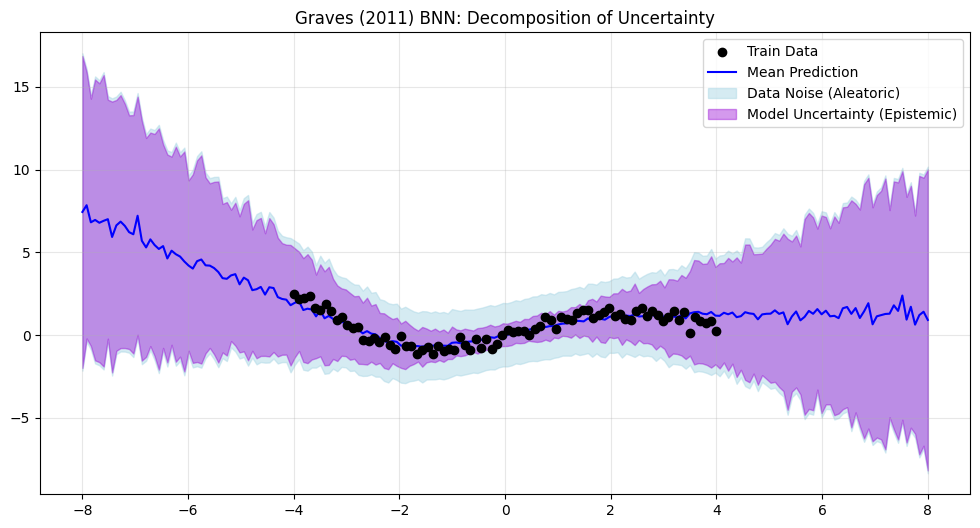

In [7]:
model.eval()
mc_preds = []

# Monte Carlo Sampling: прогоняем данные 100 раз через "дрожащую" сеть
with torch.no_grad():
    for _ in range(100):
        preds = model(x_test, sample=True) # Важно: sample=True даже на тесте!
        mc_preds.append(preds.cpu().numpy().squeeze())

mc_preds = np.stack(mc_preds)

# --- Анализ неопределенности ---
predictive_mean = mc_preds.mean(0)
predictive_std = mc_preds.std(0) # Epistemic Uncertainty (незнание модели)
noise_std = likelihood.get_noise_sigma() # Aleatoric Uncertainty (шум данных)

# Полная неопределенность
total_std = np.sqrt(predictive_std**2 + noise_std**2)

# --- График ---
plt.figure(figsize=(12, 6))

# 1. Данные
plt.scatter(x_train.cpu(), y_train.cpu(), c='k', label='Train Data', zorder=5)

# 2. Среднее предсказание
plt.plot(x_test.cpu(), predictive_mean, c='b', label='Mean Prediction')

# 3. Алеаторная неопределенность (Шум данных)
plt.fill_between(x_test.cpu().squeeze(),
                 predictive_mean - 2*total_std,
                 predictive_mean + 2*total_std,
                 color='lightblue', alpha=0.5, label='Data Noise (Aleatoric)')

# 4. Эпистемная неопределенность (Модель) - "Эффект Грейвса"
plt.fill_between(x_test.cpu().squeeze(),
                 predictive_mean - 2*predictive_std,
                 predictive_mean + 2*predictive_std,
                 color='darkviolet', alpha=0.4, label='Model Uncertainty (Epistemic)')

plt.title("Graves (2011) BNN: Decomposition of Uncertainty")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()